# Working with GrIMP Image Products Using nisarImage and nisarImageSeries Classes
---

This notebook illustrates some of the capabilities of the `nisarImage` and `nisarImageSeries` classes for working with GrIMP uncalibrated and calibrated image products. There are two classes, each derived from the same parent class so they have similar functionality. The main difference is that a `nisarImage` instance works with a single image and  date. By constrast, the `nisarImageSeries` can incorporate any number of image products, so long as they have the same geometry (resolution, and extent; e.g., all Greenand NSIDC-0723 image maps of the same type). Calibrated and uncalibrated products can not be combined in the same `nisarImageSeries` since they have different resolutions.

This notebook will help the user to:
- Search and locate Greenland Synthetic Aperture Image (SAR) mosaics covering the period from 2015 to present, including image (scaled for best contrast) and calibrated data sets ($\sigma_o$ and $\gamma_o$).
- Remotely access individual images and time-series of images.
- Create figures and plot results from the data sets.

In [ ]:
from IPython.display import Markdown, display
display(Markdown(open('Features.md', encoding='utf-8').read()))

## Environment Setup

The following packages are needed to execute this notebook. The notebook has been tested with the `environment.yml` in the *binder* folder of this repository. Thus, for best results, create a new conda environment to run this and other other GrIMP notebooks from this repository. 

`conda env create -f binder/environment.yml`

`conda activate greenlandMapping`

`python -m ipykernel install --user --name=greenlandMapping`

`jupyter lab`

See [NSIDCLoginNotebook](https://github.com/fastice/GrIMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for additional information.

The notebooks can be run on a temporary virtial instance (to start click [**binder**](https://mybinder.org/v2/gh/fastice/GrIMPNotebooks/HEAD?urlpath=lab)). See the github [README](https://github.com/fastice/GrIMPNotebooks#readme) for further details.

## Python Setup

In [7]:
#%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import grimpfunc as grimp
import nisardev as nisar
import panel as pn
pn.extension()
#from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import matplotlib.pyplot as plt
import numpy as np
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid too many NSIDC connections
import matplotlib.gridspec as gridspec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Help

**Note to get help and see options for any of the GrIMP or other functions while the cursor is positioned inside a method's parentheses, click shift+Tab.**

## Trouble Shooting

NSIDC limits the number of simultaneous connections. As a result, a download can sometimes fail, especially if multiple notebooks are downloading or the ```num_workers``` is set to large. In these cases, try rerunning with only a single notebook downloading or ```num_workers=2``` (current default).

## Login to EarthData/NSIDC

Unless the data have already been downloaded, users will need to sign in to NSIDC/EarthData to run the rest of the notebook. If a ~/.netrc exists, it will load credentials from there. If not, it will create or append to one after the login has been processed since it is needed by GDAL (see [NSIDCLoginNotebook](https://github.com/fastice/GrIMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb)) for more details on security issues.

In [8]:
# Set path for gdal 
env = dict(GDAL_HTTP_COOKIEFILE = os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR = os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)
# Get login
myLogin = grimp.NASALogin()  # If login appears not to work, try rerunning this cell
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.


## Bounding Box

The examples in this glacier will focus on Zacharie Isstrom in northern Greenland, which can be defined with the following bounding box.

In [9]:
# default from the notebook
bbox = {'minx': 440000, 'miny': -1140000, 'maxx': 500000, 'maxy': -1080000}
xbox = np.array([bbox[x] for x in ['minx', 'minx', 'maxx', 'maxx', 'minx']]) * 0.001
ybox = np.array([bbox[y] for y in ['miny', 'maxy', 'maxy', 'miny', 'miny']]) * 0.001

In [10]:
# This is for Fjord 36
bbox = {'minx': 168500, 'miny': -2902476, 'maxx': 232012, 'maxy': -2871000}  # Modifiy values as needed
xbox = np.array([bbox[x] for x in ['minx', 'minx', 'maxx', 'maxx', 'minx']]) * 0.001
ybox = np.array([bbox[y] for y in ['miny', 'maxy', 'maxy', 'miny', 'miny']]) * 0.001

## Search for Data

Greenland Mapping Project data can be searched for using instances of the class, `cmrUrls`, which provides a simple graphical and non-graphical interface to the GMP products. In this example, the search tool is used with `mode=image`, which restricts the search to **NSIDC-0723** image products. The date range can restricted with `firstDate='YYYY-MM-DD'` and `lastDate='YYYY-MM-DD'`. The images are distributed as uncalibrated **image** products or calibrated **sigma0** ($\sigma_o$) and **gamma0** ($\gamma_o$) products, which can be specified as `productFilter='image'`. In the following example, these search will be carried out based on the input parameters, but a gui search window will popup, which allows the search parameters to be altered.

In [11]:
# For some environments the tool is unresponsive (i.e., search button doesn't work) - this can often be fixed by re-running this cell
myImageUrls = grimp.cmrUrls(mode='image')  # mode image restricts search to the image products
myImageUrls.initialSearch(firstDate='2015-01-01', lastDate='2019-12-31', productFilter='image') 

Row
    [0] Column(min_width=300)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=300)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method, _pane=DataFrame)
        [1] ParamMethod(method, _pane=Markdown)
        [2] ParamMethod(method, _pane=Markdown)

If the search parameters do not need to be altered, then insering a semicolon at the end of the line will supress the output. So the corresponding sigma0 and gamma0 products can searched for as:

In [12]:
mySigma0Urls = grimp.cmrUrls(mode='image')  # mode image restricts search to the image products
mySigma0Urls.initialSearch(firstDate='2015-01-01', lastDate='2019-12-31', productFilter='sigma0');
myGamma0Urls = grimp.cmrUrls(mode='image')  # mode image restricts search to the image products
myGamma0Urls.initialSearch(firstDate='2015-01-01', lastDate='2019-12-31', productFilter='gamma0');

## Loading the data

Now that the data have been located, they can be opened for access. The list of urls is given by `myImageUrls.getCogs()` to be passed into the `readSeriesFromTiff` method.

In [13]:
myImageSeries = nisar.nisarImageSeries()  # Instantiate the series object
myImageSeries.readSeriesFromTiff(myImageUrls.getCogs(), chunkSize=2048)  # In this case increasing the chunksize can improve performance
myImageSeries.subset  # Display map of data layout - add ; to suppress this output

<xarray.DataArray 'image' (time: 251, band: 1, y: 106440, x: 59040)>
dask.array<concatenate, shape=(251, 1, 106440, 59040), dtype=uint8, chunksize=(1, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -6.26e+05 -6.26e+05 -6.259e+05 ... 8.5e+05 8.5e+05
  * y            (y) float64 -6.95e+05 -6.95e+05 ... -3.356e+06 -3.356e+06
  * time         (time) datetime64[ns] 2015-01-06T12:00:00 ... 2020-01-01T12:...
  * band         (band) <U5 'image'
    name         <U4 'None'
    _FillValue   int64 0
    time1        (time) datetime64[ns] 2015-01-01 2015-01-13 ... 2019-12-30
    time2        (time) datetime64[ns] 2015-01-12 2015-01-24 ... 2020-01-04
    spatial_ref  int64 0

At more than 100GB, downloading this full data set would take a substantial amount of time, even over a fast network. But if we use the bounding box defined above, the data set can be limited to just the region of interest as follows:

In [14]:
myImageSeries.subSetImage(bbox)
myImageSeries.subset

<xarray.DataArray 'ImageSeries' (time: 251, band: 1, y: 1260, x: 2541)>
dask.array<getitem, shape=(251, 1, 1260, 2541), dtype=uint8, chunksize=(1, 1, 1024, 1553), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1.685e+05 1.685e+05 1.686e+05 ... 2.32e+05 2.32e+05
  * y            (y) float64 -2.871e+06 -2.871e+06 ... -2.902e+06 -2.902e+06
  * time         (time) datetime64[ns] 2015-01-06T12:00:00 ... 2020-01-01T12:...
  * band         (band) <U5 'image'
    name         <U4 'None'
    _FillValue   int64 0
    time1        (time) datetime64[ns] 2015-01-01 2015-01-13 ... 2019-12-30
    time2        (time) datetime64[ns] 2015-01-12 2015-01-24 ... 2020-01-04
    spatial_ref  int64 0

Here the volume as been greatly reduced. At this stage, the data are still on the NSIDC server. At this point several actions can be taken (e.g., displaying the data), which will automatically download the data using dask. While this implicit download is convenient, it can add time for multiple operations on the data. While in principle the data are cached by the OS, they can be flushed from the cache, require re-download. The volume in this example is not large for most computers, so it makse sense to explicily download the data with as shown next:

In [15]:
myImageSeries.loadRemote()

[########################################] | 100% Completed | 401.13 s
[########################################] | 100% Completed | 401.23 s


The process can now be repeated with the sigma0 and gamma0 products.

In [ ]:
myGamma0Series = nisar.nisarImageSeries()  # Instantiate the series object
myGamma0Series.readSeriesFromTiff(myGamma0Urls.getCogs())  # Open images with lazy reads, this works well with default chunkSize
myGamma0Series.subSetImage(bbox)  # Clip image area
myGamma0Series.loadRemote()  # Download clipped regions

In [ ]:
mySigma0Series = nisar.nisarImageSeries()  # Instantiate the series object
mySigma0Series.readSeriesFromTiff(mySigma0Urls.getCogs())  # Open images with lazy reads
mySigma0Series.subSetImage(bbox)  # Clip image area
mySigma0Series.loadRemote()  # Download clipped regions

In [ ]:
myImageSeries.time

## Overview Images

The code above download a small subset, but in some cases its nice to have an overview of the full data set. As noted above, a nice feature of COGs is that they include image pyramids. A reduced resolution data set can be created as:

In [ ]:
myOverviewImage = nisar.nisarImage()  # Instantiate single image object
myOverviewImage.readDataFromTiff(myImageUrls.getCogs()[0],  overviewLevel=4)  # Open image 4->800 m res (2^(n+1) * original res) = 32*.25
myOverviewImage.loadRemote()

In [ ]:
myImageUrls.getCogs()[0]

In [ ]:
fig = plt.figure(figsize=(12,12))
myOverviewImage.displayImage()
plt.show()

## Inspect the Data

An interactive plot to inspect the data can be generated as:

In [ ]:
myGamma0Series.inspect()

In [ ]:
mySigma0Series.inspect()

## Image Types

As noted above, the GMP Sentinel image mosaics are produced as **image** (byte scaled with colortable stretch to enhance contrast), **sigm0** (calibrated radar cross section), **gamma0** (calibrated cross section that reduces topographic effects). A greater description of the characteristics of these products is beyond the scope of this notebooks but can be found in the [user guide for NSIDC-0723](https://nsidc.org/data/nsidc-0723/). The following cell illustrates how each of these products can be displayed for a given date with the overview image used as an inset map. 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(24, 11))
for mySeries, ax in zip([myImageSeries, mySigma0Series, myGamma0Series], axes):
    mySeries.displayImageForDate(date='2015-06-06', ax=ax, percentile=99)  # Clips to 1% (100-99) and 99 percentile
    ax.axis('off')
height = 3
fig.tight_layout()
axInset = inset_axes(axes[0], width=height * myOverviewImage.sx/myOverviewImage.sy, height=height, loc=2)
myOverviewImage.displayImage(date='2015-06-06', ax=axInset, colorBar=False, axisOff=True, 
                             units='km', backgroundColor=(1,1,1,.25),cmap=plt.cm.gray.with_extremes(bad=(.4,0.4,.4)), title='', extend='both')
axInset.plot(xbox, ybox, 'r')

## Image Resolution

The figure above does not capture the full resolution of the data. To better illustrate the 25-m resolution of the data, the following plot zooms in on the center of the image at 4 different levels.

In [ ]:
fig = plt.figure(figsize=(21,12))
# Use gridspec to apportion plot area
m, n = 6, 6
gs = gridspec.GridSpec(2*n, m+2*n)
# Compute center and dimensions of box
xc, yc = (bbox['maxx'] + bbox['minx']) * 0.5 * 0.001, (bbox['maxy'] + bbox['miny']) * 0.5 * 0.001
dx, dy = (bbox['maxx'] - bbox['minx']) * 0.001, (bbox['maxy'] - bbox['miny']) * 0.001
# Display the over view image
axOverview = plt.subplot(gs[:, 0:m])
myOverviewImage.displayImage(ax=axOverview, percentile=99, units='km', colorBarPosition='bottom', 
                                     colorBarPad=.25, colorBarSize='2%', midDate=False, masked=False,
                                     backgroundColor=(.9,.9,.9),cmap=plt.cm.gray.with_extremes(bad=(.4,0.4,.4)))
axOverview.axis('off')
# Create axes for zoomed images
axes = [plt.subplot(gs[n*i:n*(i+1), m+n*j:m+n*(j+1)]) for i in range(0, 2) for j in range(0,2)]
# Loop through scale factors
for ax, scale in zip(axes, [1, 2, 4, 8]):
    myImageSeries.displayImageForDate(date='2015-06-06', ax=ax, percentile=99, units='km', title='', colorBarSize='3%')
    # Zoom by adjusting plot area.
    ax.set_xlim((xc-dx*0.5/scale, xc+dx*0.5/scale))
    ax.set_ylim((yc-dy*0.5/scale, yc+dy*0.5/scale))
    # Plot zoom outlines on first image
    axes[0].plot(xc + (xbox-xc)/scale, yc+ (ybox-yc)/scale, color='w')
    # Plot zoom outlines on overview images
    axOverview.plot(xc + (xbox-xc)/scale, yc+ (ybox-yc)/scale, color='r')
fig.tight_layout() 

## Statistics

Some basic stats can also be computed for the image series. In the following the mean and standard devation are computed for the stack. Also computed are the anomaly (difference from mean for each time period). In the example below, only the anomly closest to '2020-02-28' is shown. 

In [ ]:
mean = myImageSeries.mean()
anomaly = myImageSeries.anomaly()
sigma = myImageSeries.stdev()
fig, axes = plt.subplots(1, 3, figsize=(24, 11))
for image, ax, vmin, vmax, extraTitle, extend in zip([mean, sigma, anomaly], axes, [0, 0, -10], [160, 20, 10], ['Mean', 'Sigma', 'Anomaly'], ['both', 'max', 'both']):
    # midDate=False -> the title first and last dates in series. No date specified since the stats have a single date
    image.displayImageForDate(date='2015-06-06', ax=ax, vmin=vmin, vmax=vmax, midDate=False, cmap='gray', masked=None, extend=extend)  
    # Update existing title
    ax.set_title(f'{extraTitle} for {ax.get_title()}', fontsize=18)
fig.tight_layout() 

## Time Series Plots

Values are easily plotted from the image stack. For example, to plot $\sigma_o$ and $\gamma_o$ for the center of the image:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(19, 9))
# Show mean image
mean.displayImageForDate(date='2020-02-28', ax=axes[0], percentile=99, colorBarPosition='top', title='', units='km', colorBarPad=.65)
axes[0].plot(xc, yc, 'r*', markersize=20, ) # plot point
# Plot time series
mySigma0Series.plotPoint(xc, yc, 'r*-', label='$\sigma_o$', band='sigma0', units='km', ax=axes[1])
myGamma0Series.plotPoint(xc, yc, 'k*-', label='$\gamma_o$', ax=axes[1], units='km')
# Format plot
myGamma0Series.labelPointPlot(axes[1], title='$\\sigma_o$ and $\\gamma_o$ as function of time',
                              xLabel='Radar Cross Section (dB)', plotFontSize=14)
# Create legend
axes[1].legend(fontsize=16)
# Reduce tick density
xticks = axes[1].get_xticks()
axes[1].set_xticks(xticks[range(0, len(xticks), 2)]); # Reduce tick density
fig.tight_layout()

Now plot all the points in the series along a profile that extends from x in the range of 450 to 490 and y fixed -1110 km.

In [ ]:
x = np.arange(450, 490, .2)
y = np.full(x.shape, -1110)
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
bwr = plt.cm.get_cmap('bwr', len(myGamma0Series.time))
for time, color  in zip(myGamma0Series.time, range(0, len(myGamma0Series.time))):
    # Plot profile for current time value
    myGamma0Series.plotProfile(x, y, '.', date=time, ax=ax, units='km', color=bwr(color), label=time.strftime('%Y-%m-%d'))
# Format plot
myGamma0Series.labelProfilePlot(ax, fontScale=1.3, title='$\gamma_o$ for x in range from 459 to 490 km with y=-1110 km')      
ax.legend(ncol=3, loc='lower left')

## Saving the Data to netCDF

Some downloads could take several minutes (e.g., all 6/12 day maps), in which case it useful to be able to save the data to a single netCDF file for later use. The downloaded subset can be saved in a netcdf and reloaded for to `imageSeries` instance for later analysis. Note if the data have been subsetted, **ONLY** the subset will be saved (~100MB in this example). If not, the entire Greeland data set will be saved (~2TB). Before saving, the bounds will be set to the original values, forcing a new download to overwrite the previous.

In [ ]:
myImageSeries.toNetCDF('imageSeriesFjord36.xyBounds.nc')
# Now reload the data
myImageSeriesReload = nisar.nisarImageSeries()
myImageSeriesReload.readSeriesFromNetCDF('imageSeriesFjord36.xyBounds.nc')
myImageSeriesReload.loadRemote()
#os.remove('imageSeries.xyBounds.nc')  # Comment to keep the file
myImageSeriesReload.subset

In [ ]:
pwd

In [ ]:
mySigma0Series.toNetCDF('Sigma0SeriesFjord36.xyBounds.nc')
myGamma0Series.toNetCDF('Gamma0SeriesFjord36.xyBounds.nc')

Rereading NetCDF file and slicing it by time

In [2]:
myImageSeriesReload = nisar.nisarImageSeries()
myImageSeriesReload.readSeriesFromNetCDF('imageSeriesFjord36.xyBounds.nc')
myImageSeriesReload.loadRemote()
#os.remove('imageSeries.xyBounds.nc')  # Comment to keep the file


In [ ]:
myImageSeriesReload.time

In [5]:
mySingleImageSeries = myImageSeriesReload.timeSliceImage('2019-01-12', '2019-01-12')

In [ ]:
mySingleImageSeries.toNetCDF('2019-01-12-subset.nc')

In [ ]:
myImageSeriesReload = nisar.nisarImageSeries()
# load the data with a lazy read
myImageSeriesReload.readSeriesFromNetCDF('2019-01-12-subset.nc')

In [ ]:
myImageSeriesReload.loadRemote()

In [ ]:
myImageSeriesReload.image

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
myImageSeriesReload.displayImageForDate(date='2019-01-12',ax=ax,vmin=0,vmax=160, title='reloaded', units='km')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
myGamma0Series.displayImageForDate(date='2019-01-12',ax=ax,vmin=-5,vmax=5, title='', units='km')

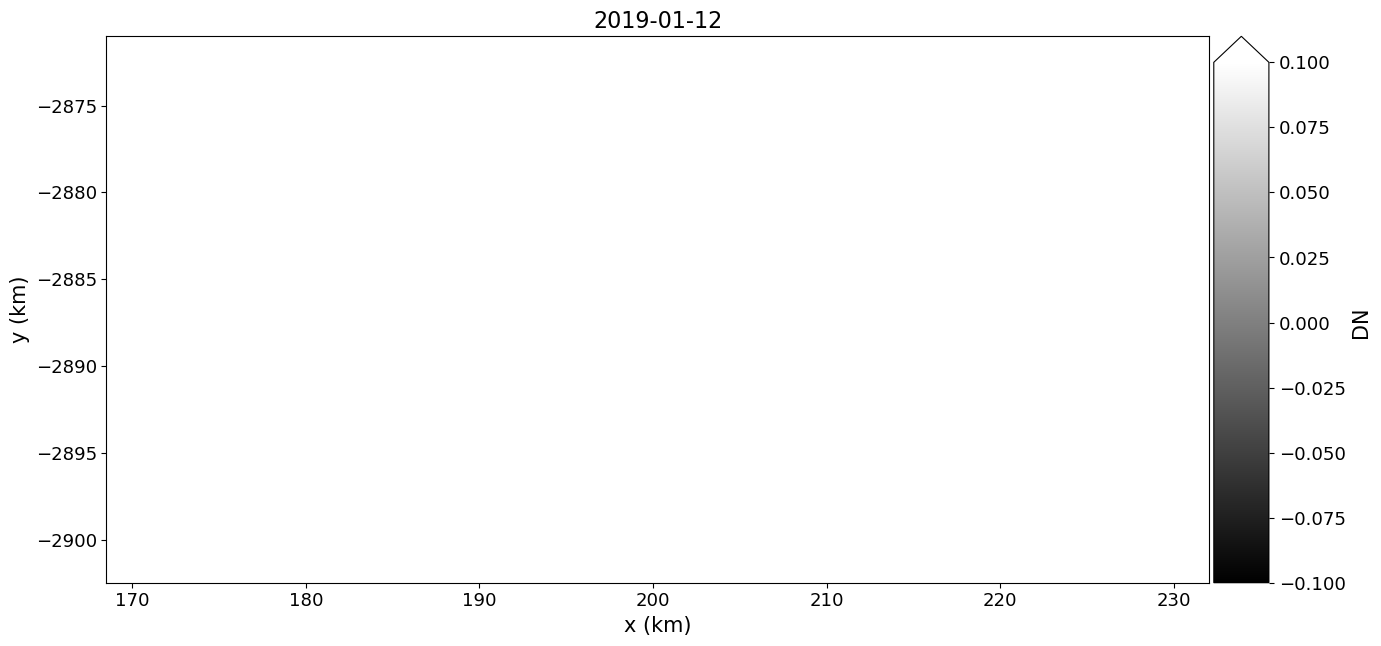

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
myImageSeries.displayImageForDate(date='2019-01-12',ax=ax,percentile=99,units='km')

In [ ]:
plt.imshow(myImageSeries.image[50,:,:],cmap='Greys',vmin=0,vmax=255)